Handling the horizontal barcodes.

Idea: compute the horixontal and vertical gradients. If the sum of the vertical gradient intensities is bigger than the sum of the horixontal gradient intensities, then this means that the barcode is rotated (i.e. it is horizontal).

In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [6]:
image_path_example = f'../images/{images_paths[10]}'

(1024, 1280, 3)


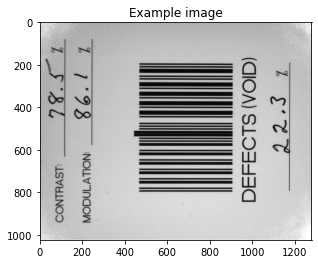

In [7]:
image = cv2.imread(image_path_example)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Example image');

## 1) UNDERSTANDING IF THE BARCODE IS ROTATED
Namely, understanding if the barcode is vertical (i.e. non-rotated) or horizontal (i.e. rotated).

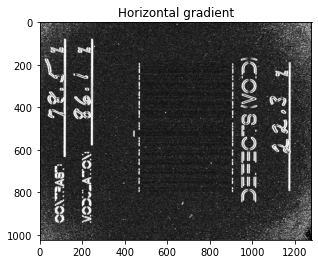

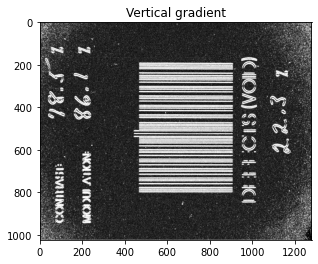

In [9]:
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F

# Horizontal gradient
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)

# Vertical gradient
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradX), 'gray')
plt.title('Horizontal gradient');

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradY), 'gray')
plt.title('Vertical gradient');

In [11]:
# By default, the barcode is non-rotated
horizontal = False
if cv2.convertScaleAbs(gradY).sum()>cv2.convertScaleAbs(gradX).sum():
    horizontal = True  # The barcode is rotated

In [12]:
horizontal

True

## 2) COMPUTING REGIONS WITH HIGH ABSOLUTE DIFFERENCE HORIZONTAL DERIVATIVE - VERTICAL DERIVATIVE 
We compute the same thing seen in the previous approaches: absolute difference between the horizontal gradient and the vertical gradient. This enlights the points in which there is an high difference between horizontal and vertical derivative: either high horiz. derivative and low vertical derivative, or the opposite. 

(So, by applying this operation, we detect the bars both horizontal and vertical.)

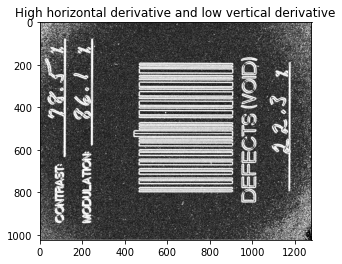

In [13]:
# Absolute difference between the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')
plt.title('High horizontal derivative and low vertical derivative');

## 3) BLURRING

As in the previous approach.

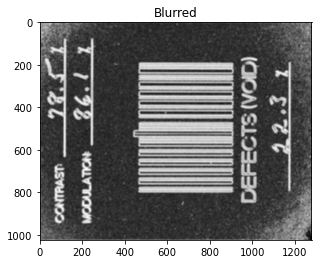

In [14]:
blurred = cv2.blur(gradient, (9, 9))

plt.figure()
plt.imshow(blurred, 'gray')
plt.title('Blurred');

## 4) BINARY THRESHOLDING (OTSU'S ALGORITHM)
As in the previous approach.

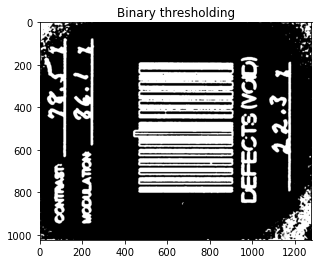

In [15]:
# Threshold, Otsu's algorithm
ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Binary thresholding');

## 5) FILLING THE BOUNDINX BOX (CLOSING OPERATOR)
If the barcode is non-rotated, we use a $25 \times 5$ structuring element, otherwise we use a $5 \times 25$ structuring element.

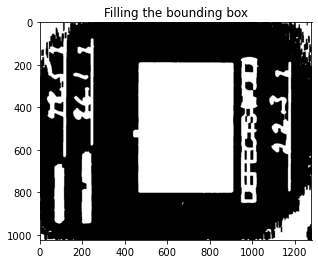

In [21]:
if not horizontal:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
else:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')
plt.title('Filling the bounding box');

What if we use the $25 \times 5$ structuring element?

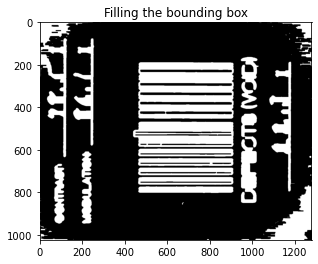

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
closed1 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed1, 'gray')
plt.title('Filling the bounding box');

Not good...

## 6) REMOVING THINGS OUTSIDE THE BOX (OPENING OPERATOR)

As in the previous approach.

Text(0.5, 1.0, 'Removing things outside the box')

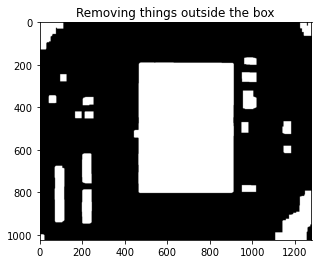

In [23]:
# Remove small things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')
plt.title('Removing things outside the box')

## 7) ENLARGING THE WIDTH OF THE BOX (DILATION OPERATOR)
If the barcode is non-rotated, we use a $10 \times 1$structuring element, otherwise we use a $1\times 10$ structuring element.

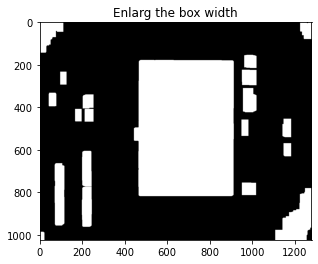

In [24]:
if not horizontal:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
else:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
dilated = cv2.dilate(opened, kernel, iterations=3)

plt.figure()
plt.imshow(dilated, 'gray')
plt.title('Enlarg the box width');

### End of the preprocessing
After this step, we have finished the pre-processing operations. We are now sure to have a box (i.e. foreground object) containing the whole barcode. In particular:
- along the heigth, we are not interested to contain all the whole bars, since we will enlarge it (According to the X dimension) and since we will shorten each bar to the smallest bars height;
- along the width, the box is slightly bigger than the barcode, because we want to be sure to contain all the bars (since we have to compute the X dimension)

This both if the barcode is rotated (i.e. horizontal) or not (i.e. vertical).

## 8) BOUNDING BOX DETECTION (OpenCV API)

As in the previous approach.

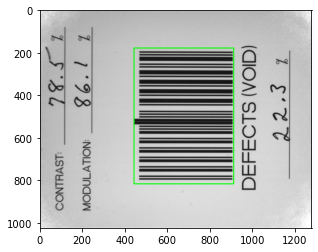

In [25]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
#print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
#print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

## 9) WARPING: REMOVAL OF PERSPECTIVE DISTORTION AND ROTATION (HOMOGRAPHY)
We have to pay attention in defining the destination dimensions and coordinates if the barcode is rotated (i.e. horizontal) or not (i.e. vertical).

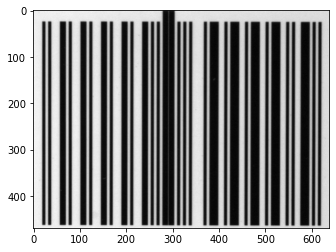

In [26]:
coordinates_source = box.astype('float32')
#print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
#print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
if not horizontal:
        destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                                 dist(coordinates_source[1],coordinates_source[3])]))
        destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                                 dist(coordinates_source[2],coordinates_source[3])]))
        coordinates_destination = np.array([[0, 0],
                                            [destination_width-1, 0],
                                            [0, destination_height-1],
                                            [destination_width-1, destination_height-1]], dtype='float32')
else:
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                                 dist(coordinates_source[2],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    coordinates_destination = np.array([[destination_width-1, 0],
                                        [destination_width-1, destination_height-1],
                                        [0, 0],
                                        [0, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

If we use the same destination dimensions and coordinates:

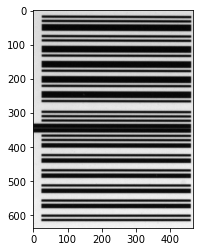

In [27]:
destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                                 dist(coordinates_source[1],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
coordinates_destination = np.array([[0, 0],
                                    [destination_width-1, 0],
                                    [0, destination_height-1],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

The barcode appears rotated, the bars are horizontal... Not correct